In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re

In [2]:
def spherical_hashing(data, bit):
    """
    Spherical Hashing function.
    :param data: 数据集
    :param bit: 哈希位数
    :return: centers, radii
    """
    N, D = data.shape
    # 初始化中心位置
    centers = random_center(data, bit)

    # 计算统计数据
    O1, O2, radii, avg, stddev = compute_statistics(data, centers)

    iter = 1
    while True:
        # 基于每对超球体的交集计算力
        forces = np.zeros((bit, D))
        for i in range(bit - 1):
            for j in range(i + 1, bit):
                force = 0.5 * (O2[i, j] - N / 4) / (N / 4) * \
                    (centers[i, :] - centers[j, :])
                forces[i, :] += force / bit
                forces[j, :] -= force / bit

        # 应用力
        centers += forces

        # 重新计算统计数据
        O1, O2, radii, avg, stddev = compute_statistics(data, centers)

        # 收敛条件
        if avg <= 0.1 * N / 4 and stddev <= 0.15 * N / 4:
            break
        if iter >= 100:
            print(f'iter exceed 100, avg = {avg}, stddev = {stddev}')

        iter += 1

    print(f'iteration = {iter}')
    return centers, radii


def random_center(data, bit):
    """
    随机初始化中心位置的函数。
    :param data: 数据集
    :param bit: 哈希位数
    :return: centers
    """
    N, D = data.shape
    centers = np.zeros((bit, D))
    for i in range(bit):
        R = np.random.permutation(N)
        sample = np.mean(data[R[:5], :], axis=0)
        centers[i, :] = sample
    return centers


def compute_statistics(data, centers):
    """
    计算统计数据的函数。
    :param data: 数据集
    :param centers: 中心点
    :return: O1, O2, radii, avg, stddev
    """
    N, D = data.shape
    bit = centers.shape[0]

    # 使用新的dist_mat函数来替换原有的距离计算
    dist = dist_mat(centers, data)
    sort_dist = np.sort(dist, axis=1)
    # 设置半径以满足平衡划分
    radii = sort_dist[:, N // 2]
    dist = dist <= np.tile(radii[:, np.newaxis], (1, N))
    dist = dist.astype(float)

    O1 = np.sum(dist, axis=1)

    avg = 0
    avg2 = 0
    O2 = np.dot(dist, dist.T)
    for i in range(bit - 1):
        for j in range(i + 1, bit):
            avg += abs(O2[i, j] - N / 4)
            avg2 += O2[i, j]

    avg /= (bit * (bit - 1) / 2)
    avg2 /= (bit * (bit - 1) / 2)
    stddev = 0
    for i in range(bit - 1):
        for j in range(i + 1, bit):
            stddev += (O2[i, j] - avg2) ** 2
    stddev = np.sqrt(stddev / (bit * (bit - 1) / 2))

    return O1, O2, radii, avg, stddev


def dist_mat(P1, P2=None):
    """
    计算向量之间的欧几里得距离矩阵。
    :param P1: 第一组向量，每个向量为一行
    :param P2: 第二组向量，每个向量为一行
    :return: 距离矩阵D
    """
    if P2 is not None:
        # 对输入的矩阵进行类型转换
        P1 = np.array(P1, dtype=float)
        P2 = np.array(P2, dtype=float)

        # 计算P1和P2每行向量的平方和
        X1 = np.sum(P1**2, axis=1).reshape(-1, 1)
        X2 = np.sum(P2**2, axis=1).reshape(-1, 1)

        # 计算P1和P2的矩阵乘法
        R = np.dot(P1, P2.T)

        # 计算欧几里得距离
        D = np.sqrt(X1 + X2.T - 2 * R)
    else:
        # 只传入P1时计算P1内部各向量的距离
        P1 = np.array(P1, dtype=float)

        # 计算P1每行向量的平方和
        X1 = np.sum(P1**2, axis=1).reshape(-1, 1)

        # 计算P1的矩阵乘法
        R = np.dot(P1, P1.T)

        # 计算欧几里得距离
        D = np.sqrt(X1 + X1.T - 2 * R)

    return D


def compactbit(b):
    """
    将二进制位数组转换为紧凑的字节串

    参数:
    b -- 二进制位数组, 形状为 (nSamples, nbits)

    返回:
    cb -- 压缩后的字节串, 形状为 (nSamples, nwords)
    """
    nSamples, nbits = b.shape
    nwords = np.ceil(nbits / 8).astype(int)
    cb = np.zeros((nSamples, nwords), dtype=np.uint8)

    for j in range(nbits):
        w = j // 8
        cb[:, w] |= (b[:, j].astype(np.uint8) << (j % 8))

    return cb


# 加载数据
# 助教给的数据是乱序的
data = np.load('../homework/data.npz')
xData = data['arr_0'][:16000]  # (16000x768)，图像数据特征
yData = data['arr_1']  # (16000x1)，图像数据标签

bit = 32  # 二进制码长度
nTrain = 16000  # 训练样本数量

# 计算训练集合，通过随机采样
nData, dim = xData.shape
R = np.random.permutation(nData)
xTrain = xData[R[2000:nTrain], :]

# 使用训练集计算超球面的中心和半径
centers, radii = spherical_hashing(xTrain, bit)

# 计算数据点到中心的距离
dData = dist_mat(xData, centers)

# 计算数据点的二进制码
th = np.repeat(radii.reshape(1, -1), dData.shape[0], axis=0)
bData = np.zeros(dData.shape, dtype=bool)
bData[dData <= th] = True
bData = compactbit(bData)


iteration = 17


In [3]:
def compute_hash(data, centers, radii):
    """
    计算数据点的哈希码。
    :param data: 数据点的特征数组。
    :param centers: 超球面哈希的中心点。
    :param radii: 超球面哈希的半径。
    :return: 哈希码数组。
    """
    dData = dist_mat(data, centers)  # 计算到中心的距离
    th = np.repeat(radii.reshape(1, -1), dData.shape[0], axis=0)
    bData = np.zeros(dData.shape, dtype=bool)
    bData[dData <= th] = True
    return compactbit(bData)

def find_most_similar(target_hash, dataset_hashes):
    """
    在数据集中找到与目标哈希码最相似的图像。
    :param target_hash: 目标图像的哈希码。
    :param dataset_hashes: 数据集中的哈希码。
    :return: 最相似图像的索引。
    """
    # 计算汉明距离
    hamming_distances = np.sum(np.bitwise_xor(target_hash, dataset_hashes), axis=1)
    # 找到最小汉明距离的索引
    most_similar_index = np.argmin(hamming_distances)
    return most_similar_index

def find_top_similar(target_hash, dataset_hashes, top_n=10):
    """
    在数据集中找到与目标哈希码最相似的前 top_n 个图像。
    :param target_hash: 目标图像的哈希码。
    :param dataset_hashes: 数据集中的哈希码。
    :param top_n: 返回的相似图像数量。
    :return: 最相似图像的索引数组。
    """
    # 计算汉明距离
    hamming_distances = np.sum(np.bitwise_xor(target_hash, dataset_hashes), axis=1)
    # 找到汉明距离最小的前 top_n 个索引
    # print(f"本次搜索到{len(hamming_distances)}")
    top_indices = np.argsort(hamming_distances)

    print(f"本次搜索到{len(top_indices)}")
    return top_indices


def find_top_similar_by_SHD(target_hash, dataset_hashes, top_n=10):
    """
    在数据集中找到与目标哈希码最相似的前 top_n 个图像，使用球形汉明距离。
    :param target_hash: 目标图像的哈希码。
    :param dataset_hashes: 数据集中的哈希码。
    :param top_n: 返回的相似图像数量。
    :return: 最相似图像的索引数组。
    """
    # 计算传统的汉明距离
    hamming_distances = np.sum(np.bitwise_xor(target_hash, dataset_hashes), axis=1)

    # 计算共同为1的位的数量
    common_ones = np.sum(np.bitwise_and(target_hash, dataset_hashes), axis=1)
    
    # 去除掉 common_ones 为 0 的情况
    valid_indices = np.where(common_ones > 0)[0]
    valid_hamming_distances = hamming_distances[valid_indices]
    valid_common_ones = common_ones[valid_indices]
    invalid_indices = np.where(common_ones == 0)[0]
    # 计算球形汉明距离
    shd = valid_hamming_distances / valid_common_ones
    #TODO 获取汉明距离的最小值和最大值
    # 找到球形汉明距离最小的前 top_n 个索引
    top_indices = valid_indices[np.argsort(shd)[:top_n]]
    top_scores_sorted = np.sort(shd)[:top_n]
    return top_indices,invalid_indices,top_scores_sorted

In [4]:
# import os 
 ## 读取tags，将 tags 读取到一个字典中并保存为tag_dict.json
# image_tag_path = "./mirflickr/meta/tags/"
# def read_tags_to_dict(folder_path):
#     tag_dict = {}
#     for filename in os.listdir(folder_path):
#         if filename.startswith("tags") and filename.endswith(".txt"):
#             tag_number = int(filename[4:-4])  # 从文件名中提取数字，例如 'tag1.txt' -> 1
#             with open(os.path.join(folder_path, filename), 'r') as file:
#                 content = file.readlines()
#                 content = [line.strip() for line in content]  # 移除每行末尾的换行符
#                 tag_dict[tag_number] = content
#     return tag_dict

# tag_dict = read_tags_to_dict(image_tag_path)
# def save_dict_to_file(dict_data, file_path):
#     with open(file_path, 'w') as file:
#         json.dump(dict_data, file)

# save_dict_to_file(tag_dict, './tag_dict.json')


In [5]:

import json

def load_dict_from_file(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)
dict_data = load_dict_from_file('./tag_dict.json')

In [6]:
# 检查是否有重复项
def check_duplicate_values_in_lists(dict_data, key1, key2):
    if key1 in dict_data and key2 in dict_data:
        # 获取两个key对应的value列表
        list1 = dict_data[key1]
        list2 = dict_data[key2]
        # 检查是否有重复项
        duplicates = set(list1) & set(list2)
        return len(duplicates)
    else:
        return 0


In [7]:
# duplicates = check_duplicate_values_in_lists(dict_data, '11637', '10529')
# # 读取duplicates的长度
# print(duplicates)

In [8]:
def extract_number_from_filename(filename):
    # 使用正则表达式提取数字
    match = re.search(r'im(\d+)\.jpg', filename)
    if match:
        return int(match.group(1))
    else:
        return "No number found in the filename."

        
def get_ground_true(number):
    image_paths = data['arr_2'][2000:] # 图像路径
    image_index_14000 = []
    for i in image_paths:
        image_index_14000.append(extract_number_from_filename(i))
    ground_true_list = []
    for image in image_index_14000:
        is_sim = check_duplicate_values_in_lists(dict_data, str(number), str(image))
        if(is_sim) > 0:
            ground_true_list.append(image)
    return ground_true_list

In [9]:
# 加载数据
# data = np.load('data.npz')
# xData = data['arr_0']  # 图像特征
def choseable_img():
   #选取出前 2000 个图片
  number  = []
  image = data['arr_2'][:2000]
  for im in image:
    name = extract_number_from_filename(im)
    number.append(name)
  
  return number 
  

def input_number_to_search(number,step = 10):
  image_path = f'./mirflickr/im{number}.jpg'
  image_paths = data['arr_2'] # 图像路径
  number = np.where(image_paths == image_path)[0][0]
# 选择待搜索图像的特征
  first_image_features = xData[number, :].reshape(1, -1)
# 计算第一个图像的哈希码
  first_image_hash = compute_hash(first_image_features, centers, radii)
# 计算整个数据集的哈希码
  dataset_hashes = compute_hash(xTrain, centers, radii)
# 找到最相似的图像
# most_similar_index = find_most_similar(first_image_hash, dataset_hashes)
  # print(image_paths[number])
  search_image = plt.imread(image_paths[number])
  # 提取出图像文件名的数字部分作为 key 值去提取标签
  search_image_key = extract_number_from_filename(image_paths[number])
  # plt.imshow(search_image)
  # plt.title("Search Image")
  # plt.show()
  # 输出最相似图像的路径
  # similar_image_path = image_paths[most_similar_index]
  # print(f"Similar image path: {similar_image_path}")
  # top_10 = find_top_similar(first_image_hash, dataset_hashes, top_n=100)
  top_10,inval_index,top_scores_sorted =find_top_similar_by_SHD(first_image_hash, dataset_hashes, top_n=step)
  i = 0
  simialy_count = 0
  FN = 0
  TN = 0
  # 计算搜索出来的
  for image  in top_10:
      img = image_paths[image]
      find_image_key = extract_number_from_filename(img)
      is_similar = check_duplicate_values_in_lists(dict_data, str(search_image_key), str(find_image_key))
      if(is_similar > 0):
         simialy_count += 1 
      # img_path = plt.imread(img)
      # 读取并显示图片
      # plt.imshow(img_path)
      # i += 1
      # # 添加标题（可选）
      # plt.title(f'Top {i}')

      # # 显示图片
      # plt.show()
      # if i == 10:
      #    break
  # 计算没搜索出来的
  for inval in inval_index:
      # FN
      img = image_paths[inval]
      find_image_key = extract_number_from_filename(img)
      is_similar = check_duplicate_values_in_lists(dict_data, str(search_image_key), str(find_image_key))
      if(is_similar > 0):
         FN += 1
      else :
         TN += 1
  
  # for socre in top_scores_sorted:
  #   print(socre)
  ap = compute_ap(top_10, get_ground_true(8038), len(get_ground_true(8038)))
  return simialy_count,len(top_10),FN,TN,ap

def compute_ap(retrieved_indices, ground_truth_relevant_indices, total_relevant):
    relevant_count = 0
    precision_sum = 0

    for i, idx in enumerate(retrieved_indices):
        if idx in ground_truth_relevant_indices:
            relevant_count += 1
            precision_sum += relevant_count / (i + 1)

    if total_relevant == 0:
        return 0

    return precision_sum / total_relevant

# 根据图像的tag，判断是否有FN,通过对比后面的 2000：16000 的图片实现
def cal_TN(image_search):
  '''
    image_search: 图片的数字
    image_list: 图片的列表
  '''
  image_paths = data['arr_2'][2000:] # 图像路径
  image_index_14000 = []
  for i in image_paths:
    image_index_14000.append(extract_number_from_filename(i))
    
  TN = 0
  TP = 0
  
  for image in image_index_14000:
    is_sim = check_duplicate_values_in_lists(dict_data, str(image_search), str(image))
    if(is_sim) == 0:
      TN +=1
    else :
      TP +=1
  
  return TN,TP

In [10]:
'''
为什么要有这个方法呢，因为data.npz里面的数据是乱序的，训练时选了后 14000 张图片，因此可以搜索的图片就只有前 2000。
'''
# choseable_img()


'\n为什么要有这个方法呢，因为data.npz里面的数据是乱序的，训练时选了后 14000 张图片，因此可以搜索的图片就只有前 2000。\n'

In [11]:
# sim_count,ser_count,fn,tn = input_number_to_search(8038)
# '''
# ser_count: 本次搜索的图片数量 
# TP: 本次搜索出 且 tag匹配的 = sim_count
# FP: 本次搜索出来 且 tag不匹配的 = ser_count-sim_count
# TN: 本次搜索没搜索出来  且 tag不匹配的 
# FN: 本次搜索没搜索出来  且 tag匹配的
# '''
# print("本次查询共",ser_count,"个结果，其中",sim_count,"个相似")
# # tn,tp = cal_TN(8038)
# print("本次tp",sim_count,"本次fp",ser_count-sim_count)
# print("本次 tn",tn,"本次 fn",fn)

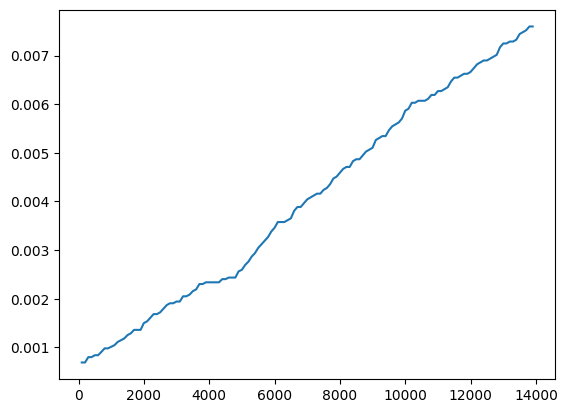

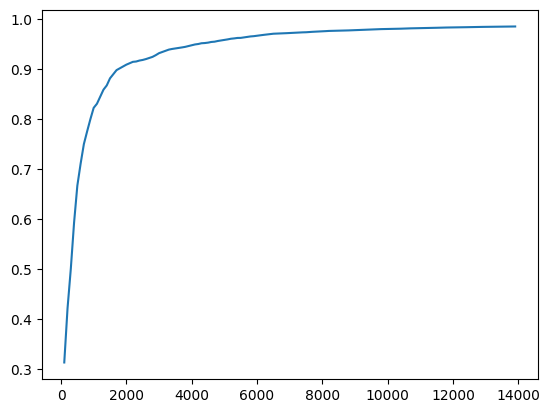

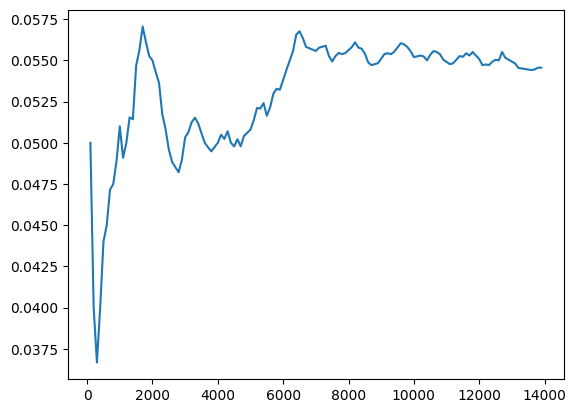

In [15]:
import matplotlib.pyplot as plt
# 计算 map
list = choseable_img()
# list到 14000，步长为 100
y_data = []
x_data = []
r_x_data = []
r_y_data = []
p_x_data = []
p_y_data = []
for i in range(100,14000,100):
    sim_count,ser_count,fn,tn,ap = input_number_to_search(17178,i)
    # print("本次查询共",ser_count,"个结果，其中",sim_count,"个相似")
    # print("本次tp",sim_count,"本次fp",ser_count-sim_count)
    # print("本次 tn",tn,"本次 fn",fn)
    precission = sim_count/ser_count
    recall = sim_count/(sim_count+fn)
    # print("第",i,"次查询 准确率 =",precission,"召回率 =",recall,"ap=",ap)
    r_y_data.append(recall)
    p_y_data.append(precission)
    y_data.append(ap)
    x_data.append(i)

plt.plot(x_data,y_data)
plt.show()

plt.plot(x_data,r_y_data)
plt.show()

plt.plot(x_data,p_y_data)
plt.show()



    

In [13]:
# def get_ground_true(number):
#     image_paths = data['arr_2'][2000:] # 图像路径
#     image_index_14000 = []
#     for i in image_paths:
#         image_index_14000.append(extract_number_from_filename(i))
#     ground_true_list = []
#     for image in image_index_14000:
#         is_sim = check_duplicate_values_in_lists(dict_data, str(number), str(image))
#         if(is_sim) > 0:
#             ground_true_list.append(image)
#     return ground_true_list
# get_ground_true(8038)

In [14]:


# ap = compute_ap(top_indices_sorted, get_ground_true(8038), len(get_ground_true(8038)))
